# 단어 사전 만들기
- 최종 수집한 데이터를 통해 감성분석 진행 후 긍정/부정 단어사전을 만들기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
import warnings

# 모델 저장
import pickle

# KFold
from sklearn.model_selection import KFold # 순서대로 하거나 or 랜덤하게 클래스를 나눈다.
from sklearn.model_selection import StratifiedKFold # 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.

# 교차검증 함수
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 불러오기

In [2]:
df = pd.read_csv('data/재보궐선거댓글데이터_최종.csv')

# 데이터 구조
df.shape

(144139, 11)

In [3]:
len(df.columns)

11

In [4]:
cols = ['title','date', 'created_date','comments','press',
        'area','party','party_eval','candidate', 'candidate_eval',
        'title_comment']
# data: 기사 작성일
# created_date: 댓글 작성일
df.columns = cols
df

,title,date,created_date,comments,press,area,party,party_eval,candidate,candidate_eval,title_comment
0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-12 19:13:00,철수야! 뜸 들이지 말고 애국하는 마음으로 물러서라~~~,조선일보,NaN,NaN,NaN,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 철수야! 뜸 들이..."
1,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-09 13:49:00,박영선은 정동영이 얻은 36프로선에 머무를것. 4.7.이후 OOO정권은 몰락의 길 ...,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 박영선은 정동영이..."
2,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:42:00,빵선이가서울시장되면서울은공산국가수도제2의평양이될것이다,조선일보,1.0,NaN,NaN,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 빵선이가서울시장되..."
3,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:38:00,서울시장후보더듬당박빵선이는절대로서울시장을할수없다이유는가족은미국.영국에 영주권자이므로...,조선일보,1.0,1.0,0.0,1.0,0.0,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 서울시장후보더듬당..."
4,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결?",2021-03-07 05:57:00,2021-03-07 14:02:00,부산은오거돈선거이고 오거돈치부선거아닌가 오거돈에 성추해으로 생긴선거가 가독도신공항은...,조선일보,2.0,1.0,0.0,NaN,NaN,"[재보궐 D-31] 부산 김영춘 vs 박형준, 서울도 양자 대결? 부산은오거돈선거이..."
...,...,...,...,...,...,...,...,...,...,...,...
144134,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:47:00,국민의힘 찍지 말라고 이 뉴스가 나온거임\n내냔에 국민의힘 찍을라 했드만 망했다 친...,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...
144135,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:41:00,굳이 일본과 해저터널 해야되는 이유가 없은이유\n-일본은고속도로비가 비싸다\n차라니...,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...
144136,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:38:00,도랏구나. 열도는 걍 갈라파고스로 남겨 둬라. 재난 난민 넘어 오면 귀찮다.,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...
144137,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토해야”,2021-04-06 21:56:00,2021-04-06 22:32:00,이걸 왜 하지? 우리한테 아무런 의미가 없는데,경향신문,NaN,NaN,NaN,NaN,NaN,[논설위원의 단도직입]“한·일해저터널 경제성 없지만…동북아 경제권 차원서 장기 검토...


# 2. 데이터 전처리

## 2.1 Feature-label 분리
- 텍스트에 대해 긍정/부정평가를 하는 것이 아니라 정당평가, 후보자평가 둘 중 하나라도 nan이 아니면 긍정/부정 라벨링 값(y)으로 받기

In [5]:
# 둘 중 하나라도 값이 있으면 인덱스 추출

# 값을 담을 리스트
A = []
B =[]
A_B = []

for p, c in zip( df['party_eval'].items(), df['candidate_eval'].items()):
    # 정당평가 有, 후보평가 無
    if (p[1] in [1.0,0.0]) & (c[1] not in [1.0,0.0]):
#         print(p[0], p[1])
        A.append(p[0])
    
    # 정당평가 無, 후보평가 有
    elif (p[1] not in [1.0,0.0]) & ( c[1] in [1.0,0.0]):
#         print(p[1], c[1])
#         print(p[0], c[0])
        B.append(c[0])
    
    # 정당평가 有, 후보평가 有
    elif (p[1] in [1.0,0.0]) & (c[1] in [1.0,0.0]):
#         print(p[1], c[1])
        A_B.append(p[0])
        
print(f'정당평가 有, 후보평가 無: {len(A)}', '\n'
      f'정당평가 無, 후보평가 有: {len(B)}', '\n'
      f'정당평가 有, 후보평가 有: {len(A_B)}' ,'\n')

print( f'가용한 총 데이터수: {len(A)+len(B)+len(A_B)}')

정당평가 有, 후보평가 無: 1780 
정당평가 無, 후보평가 有: 2330 
정당평가 有, 후보평가 有: 263 

가용한 총 데이터수: 4373


In [6]:
# 리스트를 하나로 묶기
index = A+ B + A_B
len(index)

4373

In [7]:
# 둘 중 하나라도 있는 값만을 데이터 프레임으로 형성, 혹시 모를 NaN값 삭제
index2 = df.iloc[index][['party_eval','candidate_eval']].dropna(how='all').index
df2 = df.iloc[index2]
print(df2.shape)

# 인덱스 재배열
df2.reset_index(inplace=True) 

(4373, 11)


In [8]:
# X-y값으로 나누기
X = df2['title_comment']

# 후보자 평가 nan값을 정당 평가로 채우기
y = df2['candidate_eval'].fillna( df2['party_eval'] )

In [9]:
# X-y값 구조 확인
y.shape, X.shape

((4373,), (4373,))

In [10]:
# Null값 확인
X.isna().sum()
print(X.isna().sum(), y.isna().sum())

0 0


## 2.2 Label 확인

In [11]:
# y값의 종류 확인
y.value_counts() # 부정 3271, 긍정 902

0.0    3471
1.0     902
Name: candidate_eval, dtype: int64

# 3. 모델 생성 및 학습

## Logistic 모델 흐름표
- (1) 텍스트 전처리
- (2) 형태소 분석
- (2) CounterVectorize
    - 참고 자료: https://wiserloner.tistory.com/917
- (3) TF-IDF
- (4) 분류모델 학습
- (5) 평가
- (6) 모델저장
- (7) 모델불러오기
- (8) 추정 확률 알아보기

### 3.1 텍스트 전처리
- 정규표현식

In [12]:
# 위에서 분류했던 X,y 합치기
df3 = pd.concat([X,y], axis=1)

# 컬럼 이름 변경
df3 = df3.rename( columns={'candidate_eval': 'y'} )

df3.shape

(4373, 2)

In [13]:
# 감성분석에 필요할 데이터를 csv로 저장
# df3.to_csv('data/setiment_analysis_data.csv')

In [14]:
# 정규표현식
def text_cleaning(text) :
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

# 한글 외 문자는 제거
df3['title_comment'] = df3['title_comment'].apply( lambda x: text_cleaning(x) )

In [15]:
df3

,title_comment,y
0,재보궐 부산 김영춘 박형준 서울도 양자 대결 부산은오거돈선거이고 오거돈치부선거아...,0.0
1,재보궐 부산 김영춘 박형준 서울도 양자 대결 일단 일자리와 경제를 말아드신 여당...,0.0
2,재보궐 부산 김영춘 박형준 서울도 양자 대결 수십조 세금을 평가순위 위인 가덕도...,0.0
3,재보궐 부산 김영춘 박형준 서울도 양자 대결 박원순의 성폭력 자살을 공수처에 수...,0.0
4,재보궐 부산 김영춘 박형준 서울도 양자 대결 이번 보궐선거는 임기가 년남짓이다 ...,1.0
...,...,...
4368,나경원 대세론 꺾은 오세훈임기 못마친 죄 갚겠다 울먹 쟤 쥐새끼 똘마니야벌써 잊는거...,0.0
4369,나경원 대세론 꺾은 오세훈임기 못마친 죄 갚겠다 울먹 이런자가 시장 후보라니 국민의...,0.0
4370,나경원 대세론 꺾은 오세훈임기 못마친 죄 갚겠다 울먹 그럼 저 치가 아이들 점심을 ...,0.0
4371,나경원 대세론 꺾은 오세훈임기 못마친 죄 갚겠다 울먹 정권심판이라이명박 박근혜정권때...,0.0


### 3.2 형태소 분류
- 조사 제외

In [16]:
# 형태소 분류 태그
from konlpy.tag import Okt

In [17]:
def get_pos(x):
    tagger = Okt()  # Okt로 형태소 분리하기
    pos = tagger.pos(x)
    results = []  # 형태소를 담을 리스트
    for i in pos:
        if i[1] != 'Josa':  # 조사는 빼버리기
            results.append(f'{i[0]}/{i[1]}')  # '단어/품사'의 형태로 리스트에 추가
        else:
            pass
    return results


# 제목_댓글의 첫번째 데이터만 가져와서 형태소 분리
print(get_pos(df3['title_comment'][0]))

['재보궐/Noun', '부산/Noun', '김영춘/Noun', '박형준/Noun', '서울/Noun', '양자/Noun', '대결/Noun', '부산/Noun', '오거돈/Noun', '선거/Noun', '오거돈/Noun', '치부/Noun', '선거/Noun', '아닌가/Adjective', '오거돈/Noun', '성/Noun', '추해으로/Adjective', '생긴/Verb', '선거/Noun', '가독/Noun', '신/Modifier', '공항/Noun', '오거돈/Noun', '재산/Noun', '불려줄려고/Verb', '문재인/Noun', '민주당/Noun', '들/Suffix', '발악/Noun', '아닌가다/Adjective', '부산/Noun', '사람/Noun', '하는말/Verb', '이번/Noun', '선거/Noun', '쎄/Adjective', '빠지게/Verb', '오거돈/Noun', '위/Noun', '선가아이가다/Verb']


### 3.3 텍스트를 숫자 벡터화
- CounterVectorize: 
    - Convert a collection of text documents to **a matrix of token counts**
    - 단어들의 **카운트(출현 빈도(frequency))**로 여러 문서들을 **벡터화**
    - 카운트 행렬, 단어 문서 행렬 (Term-Document Matrix, TDM))
    - 모두 소문자로 변환시키기 때문에 me 와 Me 는 모두 같은 특성이 된다.

In [18]:
# 단어당 몇개씩 들어 있는지에 대한 벡터를 생성
from sklearn.feature_extraction.text import CountVectorizer

index_vectorizer = CountVectorizer(tokenizer= lambda x : get_pos(x))
X = index_vectorizer.fit_transform(df3['title_comment'].tolist())

In [19]:
# { 단어: 단어 인덱스 } 형태의 사전 확인
index_vectorizer.vocabulary_

{'재보궐/Noun': 15249,
 '부산/Noun': 8891,
 '김영춘/Noun': 2215,
 '박형준/Noun': 7867,
 '서울/Noun': 10189,
 '양자/Noun': 12328,
 '대결/Noun': 4234,
 '오거돈/Noun': 13091,
 '선거/Noun': 10223,
 '치부/Noun': 17783,
 '아닌가/Adjective': 11577,
 '성/Noun': 10333,
 '추해으로/Adjective': 17626,
 '생긴/Verb': 10111,
 '가독/Noun': 176,
 '신/Modifier': 11005,
 '공항/Noun': 1371,
 '재산/Noun': 15252,
 '불려줄려고/Verb': 9084,
 '문재인/Noun': 7303,
 '민주당/Noun': 7561,
 '들/Suffix': 5310,
 '발악/Noun': 8022,
 '아닌가다/Adjective': 11578,
 '사람/Noun': 9711,
 '하는말/Verb': 18874,
 '이번/Noun': 14171,
 '쎄/Adjective': 11337,
 '빠지게/Verb': 9380,
 '위/Noun': 13723,
 '선가아이가다/Verb': 10222,
 '일단/Noun': 14429,
 '일자리/Noun': 14503,
 '경제/Noun': 1097,
 '말/Noun': 6334,
 '드신/Verb': 5275,
 '여당/Noun': 12837,
 '빼고/Verb': 9413,
 '지/Verb': 16434,
 '들/Verb': 5311,
 '성범죄/Noun': 10350,
 '하는데/Verb': 18867,
 '선/Noun': 10221,
 '가비/Noun': 255,
 '토안/Noun': 18163,
 '하는/Verb': 18825,
 '비/Noun': 9210,
 '양심/Noun': 12325,
 '정당/Noun': 15597,
 '님/Suffix': 3869,
 '수십조/Modifier': 10664,
 '세금/Noun

In [20]:
# 실제 형태소
print(get_pos(df3['title_comment'][0]))

# 결과
print( X[0]) # ( 문장 순서 , 단어 인덱스)    등장 횟수

['재보궐/Noun', '부산/Noun', '김영춘/Noun', '박형준/Noun', '서울/Noun', '양자/Noun', '대결/Noun', '부산/Noun', '오거돈/Noun', '선거/Noun', '오거돈/Noun', '치부/Noun', '선거/Noun', '아닌가/Adjective', '오거돈/Noun', '성/Noun', '추해으로/Adjective', '생긴/Verb', '선거/Noun', '가독/Noun', '신/Modifier', '공항/Noun', '오거돈/Noun', '재산/Noun', '불려줄려고/Verb', '문재인/Noun', '민주당/Noun', '들/Suffix', '발악/Noun', '아닌가다/Adjective', '부산/Noun', '사람/Noun', '하는말/Verb', '이번/Noun', '선거/Noun', '쎄/Adjective', '빠지게/Verb', '오거돈/Noun', '위/Noun', '선가아이가다/Verb']
  (0, 15249)	1
  (0, 8891)	3
  (0, 2215)	1
  (0, 7867)	1
  (0, 10189)	1
  (0, 12328)	1
  (0, 4234)	1
  (0, 13091)	5
  (0, 10223)	4
  (0, 17783)	1
  (0, 11577)	1
  (0, 10333)	1
  (0, 17626)	1
  (0, 10111)	1
  (0, 176)	1
  (0, 11005)	1
  (0, 1371)	1
  (0, 15252)	1
  (0, 9084)	1
  (0, 7303)	1
  (0, 7561)	1
  (0, 5310)	1
  (0, 8022)	1
  (0, 11578)	1
  (0, 9711)	1
  (0, 18874)	1
  (0, 14171)	1
  (0, 11337)	1
  (0, 9380)	1
  (0, 13723)	1
  (0, 10222)	1


### 3.4 TF-IDF로 변환 및 저장
- Tf(Term-Frequency) : 특정 단어가 하나의 데이터 안에서 등장하는 횟수
- Tf-Idf(Term-Freuquency times Inverse Documnet-Frquency) : 특정 단어가 여러 데이터에 자주 등장하는지를 알려주는 지표.
- 아예 등장하지 않는다면 0, 그 이외에는 실수값이 크다면 그 단어가 보다 가치있는 특징이라는 것이고, 작다면 그다지 가치가 없다고 판단 가능
- 아예 등장하지 않는다면 0, 그 이외에는 실수값이 크다면 그 단어가 보다 가치있는 특징이라는 것이고, 작다면 그다지 가치가 없다고 판단 가능


- 사용 목적
    - **Transform**
        - 단어 빈도 매트릭스를 정규화된 tf 또는 tf-idf로 나타내기 위해
    - **Sclae Down**
        - 형태소에서 매우 빈번하게 나타나 경험적으로 덜 유익한 토큰의 영향을 줄이기 위해 사용한다. 

In [21]:
# 위에서 만든 형태소 벡터를 학습 데이터 벡터로 생성
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)
print(X[0]) # (문장 번호, 단어 인덱스)    단어의 비중

  (0, 18874)	0.20225611778219826
  (0, 17783)	0.17668721752676989
  (0, 17626)	0.20225611778219826
  (0, 15252)	0.1337277867749289
  (0, 15249)	0.13701122411154956
  (0, 14171)	0.09394070094833018
  (0, 13723)	0.10115918967936799
  (0, 13091)	0.5397781022947776
  (0, 12328)	0.13922945569868952
  (0, 11578)	0.20225611778219826
  (0, 11577)	0.11418358455522618
  (0, 11337)	0.18612393784494766
  (0, 11005)	0.1045712119618201
  (0, 10333)	0.1605550375895193
  (0, 10223)	0.2540831054694538
  (0, 10222)	0.20225611778219826
  (0, 10189)	0.07543964931231611
  (0, 10111)	0.16479835595411788
  (0, 9711)	0.07699181209079847
  (0, 9380)	0.20225611778219826
  (0, 9084)	0.20225611778219826
  (0, 8891)	0.23227146323686368
  (0, 8022)	0.14753064271366112
  (0, 7867)	0.07900231170639177
  (0, 7561)	0.05463027236803248
  (0, 7303)	0.07693837046916746
  (0, 5310)	0.04906727583040895
  (0, 4234)	0.12598445428017715
  (0, 2215)	0.11167860828147955
  (0, 1371)	0.10177169387060915
  (0, 176)	0.19281939746402

※ (주의) tfidf_vectorizer도 저장해야한다.
- TfidTransformer를 새롭게 생성한 후 저장한 모델을 사용하면 안 된다.
- "학습 단계에서 생성해서 학습을 시킨 녀석을 그대로 사용해야 합니다. 그녀석도 파일로 저장해 두었다가 사용할 때 불러와서 써야 합니다"

In [22]:
# TF-IDF 저장
with open('model/05.단어사전 만들기/tfidf_vectorizer1.dat','wb') as fp:
    pickle.dump(tfidf_vectorizer, fp)
print('저장완료')

저장완료


### 3.5 Train-Test Data Set

In [23]:
# 학습-테스트용으로 나누기
from sklearn.model_selection import train_test_split

# 결과값
y = df3['y'] 
X_train, X_test, y_train, y_test = train_test_split( X, y,
                                                    test_size=0.3, 
                                                    stratify=y )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3061, 20238), (1312, 20238), (3061,), (1312,))

### 3.6 모델 학습

In [24]:
# 로지스틱회귀로 분류분석 진행하기
from sklearn.linear_model import LogisticRegression

# 교차검증: 결과데이터를 보고 각 클래스가 균등한 비율로 들어있게끔 나눈다.
from sklearn.model_selection import StratifiedKFold 

# 평가 방법
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [25]:
# 교차검증
fold1 = StratifiedKFold( n_splits=10 )

# 로지스틱 회귀 모델 생성
lr = LogisticRegression()

# 최적 파라미터 찾기
params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}

logi_model = GridSearchCV( lr, params, scoring='accuracy', cv=fold1 )

In [26]:
logi_model.fit( X_train,y_train )
print(f'최적의 하이퍼 파라미터: {logi_model.best_params_}')
print(f'최적의 모델 평균 성능: {logi_model.best_score_}')

최적의 하이퍼 파라미터: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
최적의 모델 평균 성능: 0.9150646143365055


# 4. 모델 성능 평가

In [27]:
# 최고 성능 모델
best_model = logi_model.best_estimator_

### 4.1 학습데이터 교차검증

In [28]:
from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score, roc_auc_score 

# 훈련용 데이터의 교차검증
accuracy = cross_val_score( best_model, X_train, y_train, scoring='accuracy', cv=fold1 )
precision = cross_val_score( best_model, X_train, y_train, scoring='precision', cv=fold1 )
recall_score = cross_val_score( best_model, X_train, y_train, scoring='recall', cv=fold1 )
f1_score = cross_val_score( best_model, X_train, y_train, scoring='f1', cv=fold1 )
roc_auc_score = cross_val_score( best_model, X_train, y_train, scoring='roc_auc', cv=fold1 )

In [29]:
print('평균 정확도', accuracy.mean() )
print('평균 정밀도', precision.mean() )
print('평균 재현율', recall_score.mean() )
print('평균 f1', f1_score.mean() )
print('평균 roc-acu', roc_auc_score.mean() )

평균 정확도 0.9150635498499075
평균 정밀도 0.8822501166185542
평균 재현율 0.6767361111111112
평균 f1 0.7662613232817864
평균 roc-acu 0.9254619423215104


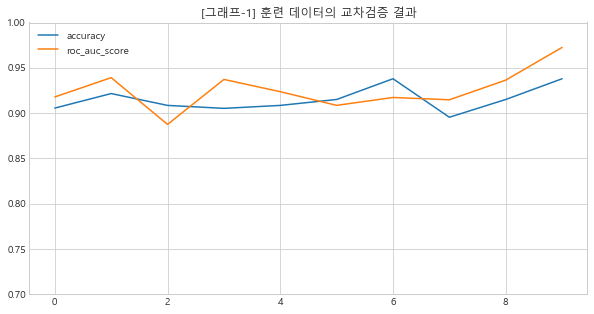

In [30]:
plt.plot( accuracy , label='accuracy')
# plt.plot( precision , label='precision')
# plt.plot( recall_score , label='recall_score')
# plt.plot( f1_score , label='f1_score')
plt.ylim(0.7, 1.0)
plt.plot( roc_auc_score , label='roc_auc_score')
plt.legend()
plt.title( '[그래프-1] 훈련 데이터의 교차검증 결과')
plt.show()

### 4.2 테스트 데이터 검증 및 예측

In [31]:
# 테스트용 데이터를 통해 예측하기
y_pred = best_model.predict(X_test)

# 테스트 데이터 정확도
result = accuracy_score( y_test, y_pred ) 
result # 정확도

0.9047256097560976

### 4.3 모델 저장

In [32]:
with open('model/05.단어사전 만들기/sentiment_analysis_model.dat','wb') as fp:
    pickle.dump(best_model, fp)
print('저장완료')

저장완료


### 4.3 모델 불러오기

In [33]:
with open('model/05.단어사전 만들기/sentiment_analysis_model.dat', 'rb') as fp:
    best_model = pickle.load(fp)
print('출력 완료')

출력 완료


### 4.4 로지스틱 모델의 추정확률 파악

In [34]:
# 클래스 순서에 따른 추정 확률 [ 0일 확률, 1일 확률 ]
proba = best_model.predict_proba( X_test )
proba

array([[9.81950579e-01, 1.80494205e-02],
       [9.99919922e-01, 8.00778880e-05],
       [9.88159489e-01, 1.18405114e-02],
       ...,
       [9.95278719e-01, 4.72128148e-03],
       [9.97346325e-01, 2.65367455e-03],
       [9.99150777e-01, 8.49222638e-04]])

In [35]:
# 각 값에 대한 추정 확률과 실제 값을 데이터 프레임으로 형성
proba_df = pd.DataFrame(proba)
proba_df['target'] = best_model.predict(X_test)
proba_df

,0,1,target
0,0.981951,0.018049,0.0
1,0.999920,0.000080,0.0
2,0.988159,0.011841,0.0
3,0.999180,0.000820,0.0
4,0.898333,0.101667,0.0
...,...,...,...
1307,0.995809,0.004191,0.0
1308,0.990371,0.009629,0.0
1309,0.995279,0.004721,0.0
1310,0.997346,0.002654,0.0


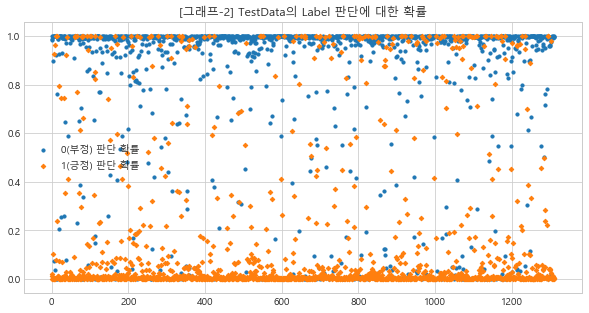

In [36]:
plt.scatter( range(len(proba_df[0])), proba_df[0] , label='0(부정) 판단 확률',s=10)
plt.scatter( range(len(proba_df[1])), proba_df[1] , label='1(긍정) 판단 확률',marker='D', s=10)
plt.legend()
plt.title( '[그래프-2] TestData의 Label 판단에 대한 확률')
plt.show()

※ CounterVectorizer는 생성한 후 fit 시키지 않고 transform
- **NOT** fit_transform 

In [38]:
# 2. 임의의 텍스트로 예측
test = [
    '박영선 아웃',
    'ㅎㅎ',
    '오세훈은 뭐냐? 무상급식 기억 안 나냐?',
    '더불어 만진당에서 나온 후보라..',
    '국민의 짐',
    '성추행당은 꺼져라',
    '오세훈 후보 지지합니다',
    '참나',
    '노답',
    '누굴 뽑으라는거야',
    '둘다 별로야'
]

# CounterVectorrizer는 다시 fit시키는 것이 아니라 transform만 시키는 것
X = index_vectorizer.transform(test)

# tf-idf는 새로 생성하는 것이 아니라 학습시킨 td-idf를 저장하여 사용하는 것
X = tfidf_vectorizer.transform(X)

y_pred = best_model.predict(X)
y_pred

array([0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])

### 4.5 후보자의 이름이나, 정당의 이름이 들어갈 경우 ?

In [39]:
test2 = [
    '박영선',
    '오세훈',
    '김영춘',
    '박형준',
    '더불어 민주당',
    '국민의 힘',
]

# CounterVectorizer & Tf-Idf
X = index_vectorizer.transform(test2)
X = tfidf_vectorizer.transform(X)

# 긍정/부정 예측 결과
best_model.predict(X)

array([0., 1., 1., 0., 0., 0.])

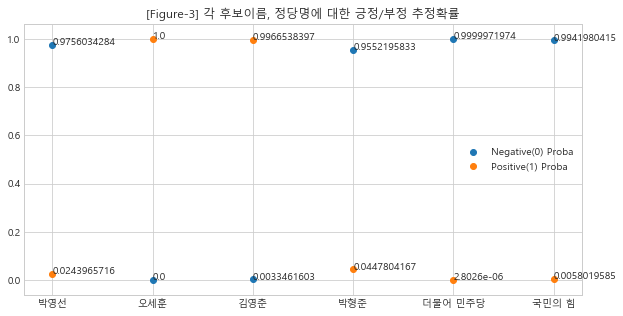

In [40]:
# 추정 확률 알아보기
proba_0 = best_model.predict_proba(X)[:,0]
proba_1 = best_model.predict_proba(X)[:,1]

plt.scatter( test2, proba_0 , label='Negative(0) Proba')
plt.scatter( test2, proba_1 , label='Positive(1) Proba')

for idx, val in zip(test2, proba_0):
    plt.text(idx, val, f'{round(val,10)}' )    
for idx, val in zip(test2, proba_1):
    plt.text(idx, val, f'{round(val,10)}' )    
plt.title('[Figure-3] 각 후보이름, 정당명에 대한 긍정/부정 추정확률')
plt.legend()
plt.show()

- 위 모델은 **여당**과 **여당의 후보**가 글에 포함될 경우 **부정**으로 판단함을 알 수 있음
    - 보수 언론의 데이터가 많아서 이러한 도출 되었거나
    - 실제 여론을 반영한 결과라고 해석할 수 있다.
- 기존 모델과 차이점은 박형준 후보 역시 부정적으로 평가한다는 것

# 5. 단어 사전 만들기

### 5.1 (단어 인덱스, 회귀계수) 형태로 만들기

In [41]:
# (단어인덱스, 회귀 계수) 형태로 만들기
wordidx_coef = list(enumerate(best_model.coef_[0]))
wordidx_coef[:10]

[(0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (7, -0.07836287052506329),
 (8, 0.0),
 (9, 0.1273602704216957)]

### 5.2 (회귀계수, 단어 인덱스) 형태로 변형
- 정렬

In [42]:
wordidx_coef2 = ( (coef, idx) for idx, coef in wordidx_coef )

In [43]:
# 오름차순 정렬: 회귀계수가 가장 높은 것부터 출력
coef_pos_index = sorted(wordidx_coef2, reverse=True) 
coef_pos_index[:10] # 결과적으로 중요도 나타냄

[(27.861048576265606, 13162),
 (19.336231191402483, 19930),
 (18.138103347526283, 10851),
 (14.332405049113952, 19319),
 (12.168903465382009, 7578),
 (11.83414382253818, 10845),
 (10.751871655222326, 8275),
 (9.909581201020224, 4161),
 (9.733345239200913, 14023),
 (9.69570724705977, 325)]

### 5.3 단어사전 만들기
- 단어 사전 변형하기
    - { 단어: 단어 인덱스 }에서 { 단어 인덱스: 단어 } 형태로  변형
- 긍정 단어 20개, 부정 단어 20개 파악

In [44]:
index_vectorizer.vocabulary_ # {단어: 인덱스, ...} 딕셔너리
index_vectorizer.vocabulary_.items() #  [ (단어: 인덱스), ..] 형태

# 단어 사전
word_dict={}

for pos, index in index_vectorizer.vocabulary_.items():
    # print(pos)
    word_dict[index] = pos
    
word_dict

{15249: '재보궐/Noun',
 8891: '부산/Noun',
 2215: '김영춘/Noun',
 7867: '박형준/Noun',
 10189: '서울/Noun',
 12328: '양자/Noun',
 4234: '대결/Noun',
 13091: '오거돈/Noun',
 10223: '선거/Noun',
 17783: '치부/Noun',
 11577: '아닌가/Adjective',
 10333: '성/Noun',
 17626: '추해으로/Adjective',
 10111: '생긴/Verb',
 176: '가독/Noun',
 11005: '신/Modifier',
 1371: '공항/Noun',
 15252: '재산/Noun',
 9084: '불려줄려고/Verb',
 7303: '문재인/Noun',
 7561: '민주당/Noun',
 5310: '들/Suffix',
 8022: '발악/Noun',
 11578: '아닌가다/Adjective',
 9711: '사람/Noun',
 18874: '하는말/Verb',
 14171: '이번/Noun',
 11337: '쎄/Adjective',
 9380: '빠지게/Verb',
 13723: '위/Noun',
 10222: '선가아이가다/Verb',
 14429: '일단/Noun',
 14503: '일자리/Noun',
 1097: '경제/Noun',
 6334: '말/Noun',
 5275: '드신/Verb',
 12837: '여당/Noun',
 9413: '빼고/Verb',
 16434: '지/Verb',
 5311: '들/Verb',
 10350: '성범죄/Noun',
 18867: '하는데/Verb',
 10221: '선/Noun',
 255: '가비/Noun',
 18163: '토안/Noun',
 18825: '하는/Verb',
 9210: '비/Noun',
 12325: '양심/Noun',
 15597: '정당/Noun',
 3869: '님/Suffix',
 10664: '수십조/Modifier',
 10393: '

In [45]:
coef_pos_text = []

for value, index in coef_pos_index:
    # 각 인덱스에 해당하는 실제 단어 확인
    # print(word_dict[index])
    # print(value) # 회귀계수
    coef_pos_text.append( ( value, word_dict[index]) )
    
coef_pos_text

[(27.861048576265606, '오세훈/Noun'),
 (19.336231191402483, '화이팅/Noun'),
 (18.138103347526283, '승리/Noun'),
 (14.332405049113952, '합니다/Verb'),
 (12.168903465382009, '믿고싶은/Verb'),
 (11.83414382253818, '승/Noun'),
 (10.751871655222326, '번/Noun'),
 (9.909581201020224, '당선/Noun'),
 (9.733345239200913, '이긴다/Verb'),
 (9.69570724705977, '가즈/Noun'),
 (9.561365709182573, '김영춘/Noun'),
 (9.516626263872054, '필승/Noun'),
 (9.41565959202317, '승자/Noun'),
 (8.953626326359847, '님/Suffix'),
 (8.881317216406226, '나이스/Noun'),
 (8.842801906858936, '그래도/Adverb'),
 (8.752314127573364, '실력/Noun'),
 (8.701540485457025, '시장님/Noun'),
 (8.354188131628577, 'ㅜ/KoreanParticle'),
 (8.12233913576816, '선관위/Noun'),
 (8.000895102601687, '링/Noun'),
 (7.9803044613390925, '세훈/Noun'),
 (7.8582676609962165, '한/Determiner'),
 (7.817680635124265, '청춘/Noun'),
 (7.723580695280305, '응원/Noun'),
 (7.617159719334554, '가자/Verb'),
 (7.5166121639922245, '화이/Noun'),
 (7.3226068913259414, '힘내세요/Verb'),
 (7.315482041636965, '뽑을거야/Verb'),
 (7.295

### 5.4 명사 리스트 

In [46]:
# 회귀 계수가 높은 순으로 명사들을 리스트에 담는다.
noun_list = []
for i in coef_pos_text:
    if i[1].split('/')[1] == 'Noun':
        noun_list.append((float(i[0]),i[1].split('/')[0]))

In [47]:
# '긍정' 평가에 영향을 준 명사 리스트
np.array(noun_list[:50])

array([['27.861048576265606', '오세훈'],
       ['19.336231191402483', '화이팅'],
       ['18.138103347526283', '승리'],
       ['11.83414382253818', '승'],
       ['10.751871655222326', '번'],
       ['9.909581201020224', '당선'],
       ['9.69570724705977', '가즈'],
       ['9.561365709182573', '김영춘'],
       ['9.516626263872054', '필승'],
       ['9.41565959202317', '승자'],
       ['8.881317216406226', '나이스'],
       ['8.752314127573364', '실력'],
       ['8.701540485457025', '시장님'],
       ['8.12233913576816', '선관위'],
       ['8.000895102601687', '링'],
       ['7.9803044613390925', '세훈'],
       ['7.817680635124265', '청춘'],
       ['7.723580695280305', '응원'],
       ['7.5166121639922245', '화이'],
       ['7.295011632701652', '집값'],
       ['7.261635775468757', '현직'],
       ['7.186168382186028', '숲'],
       ['6.942668340871342', '후보'],
       ['6.800726649349511', '압승한다'],
       ['6.710070632882537', '의원님'],
       ['6.670185140109638', '위법'],
       ['6.643463141033737', '보궐선거'],
       ['6.6018876

In [48]:
# '부정' 평가에 영향을 준 명사 리스트
np.array(noun_list[-50:])

array([['-4.387558653638544', '내'],
       ['-4.411173534847394', '발리'],
       ['-4.516377087745787', '죄'],
       ['-4.5280131139147235', '입'],
       ['-4.564777384755685', '김종인'],
       ['-4.574008215641635', '영선'],
       ['-4.589417024633826', '제'],
       ['-4.7048035032903215', '범'],
       ['-4.710340188905913', '너'],
       ['-4.733254285804334', '단합'],
       ['-4.745348451350405', '비리'],
       ['-4.785422413206801', '비용'],
       ['-4.796214254488137', '땅'],
       ['-4.822230304276496', '확정'],
       ['-4.841739675942445', '여자'],
       ['-4.896672080281485', '저'],
       ['-4.979321636939022', '냄새'],
       ['-5.131325417766657', '게'],
       ['-5.168382569393336', '느무싫다'],
       ['-5.198020890771751', '모든'],
       ['-5.238537087623753', '데'],
       ['-5.3182383414948475', '금태섭'],
       ['-5.31986794518343', '네'],
       ['-5.342075457343725', '문제'],
       ['-5.406482516886564', '진짜'],
       ['-5.4380059556081966', '불당'],
       ['-5.512381928249165', '선회'],
     

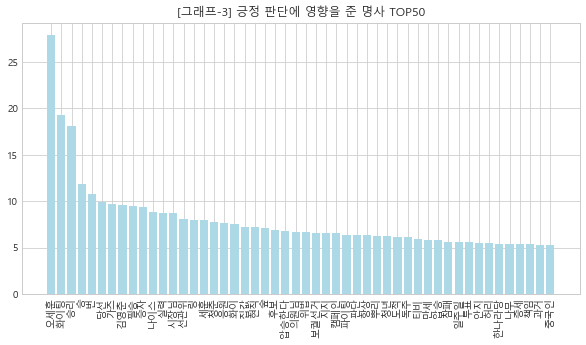

In [49]:
# 긍정 판단에 영향을 주는 명사 top 50
np.array(noun_list[:50])[:,1]

plt.bar( np.array(noun_list[:50])[:,1],
         np.array(noun_list[:50])[:,0].astype(float), color='lightblue')
plt.title('[그래프-3] 긍정 판단에 영향을 준 명사 TOP50')
plt.xticks(rotation=90)
plt.show()

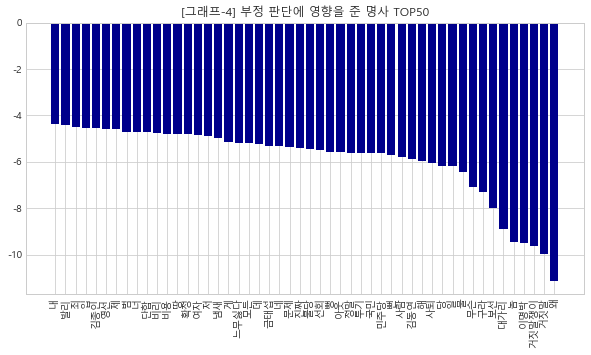

In [50]:
# 부정 판단에 영향을 주는 명사 top 50
np.array(noun_list[-50:])[:,1]

plt.bar( np.array(noun_list[-50:])[:,1],
         np.array(noun_list[-50:])[:,0].astype(float), color='darkblue')
plt.title('[그래프-4] 부정 판단에 영향을 준 명사 TOP50')
plt.xticks(rotation=90)
plt.show()

### 5.5 형용사 리스트

In [51]:
# 회귀 계수가 높은 순으로 형용사들을 리스트에 담는다.
adjective_list = []
for i in coef_pos_text:
    if i[1].split('/')[1] == 'Adjective':
        adjective_list.append((float(i[0]),i[1].split('/')[0]))

In [52]:
# 형용사 리스트 확인
adjective_list[:10]

[(6.792759600208145, '중요한가긴'),
 (6.515817808055208, '있게'),
 (6.492322323902865, '입니다'),
 (5.51267451129318, '야합니다'),
 (5.460278337201187, '화해서'),
 (5.195149042850389, '실패해서'),
 (5.189652003902126, '확실하고'),
 (5.189652003902126, '투명하겠지'),
 (5.107330409878085, '애매해도'),
 (5.029950837846688, '아니다오')]

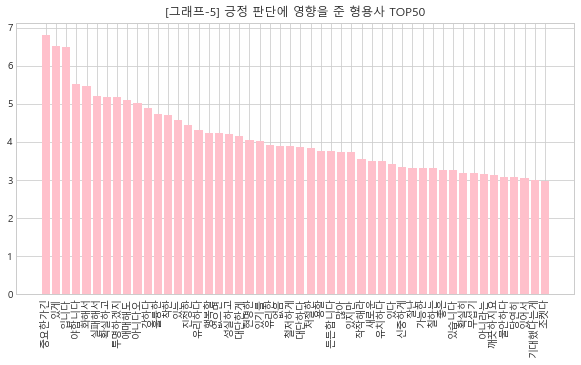

In [53]:
# 긍정 판단에 영향을 주는 형용사 top 50
np.array(adjective_list[:50])[:,1]

plt.bar( np.array(adjective_list[:50])[:,1],
         np.array(adjective_list[:50])[:,0].astype(float), color='pink')
plt.title('[그래프-5] 긍정 판단에 영향을 준 형용사 TOP50')
plt.xticks(rotation=90)
plt.show()

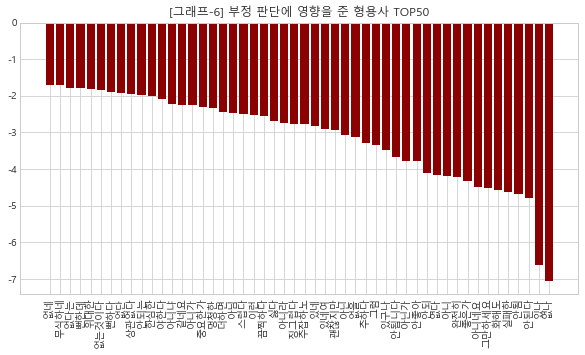

In [54]:
# 부정 판단에 영향을 주는 형용사 top 50
np.array(adjective_list[-50:])[:,1]

plt.bar( np.array(adjective_list[-50:])[:,1],
         np.array(adjective_list[-50:])[:,0].astype(float), color='darkred')
plt.title('[그래프-6] 부정 판단에 영향을 준 형용사 TOP50')
plt.xticks(rotation=90)
plt.show()

### 5.6 동사 리스트

In [55]:
# 회귀 계수가 높은 순으로 동사들을 리스트에 담는다.
verb_list = []
for i in coef_pos_text:
    if i[1].split('/')[1] == 'Verb':
        verb_list.append((float(i[0]),i[1].split('/')[0]))

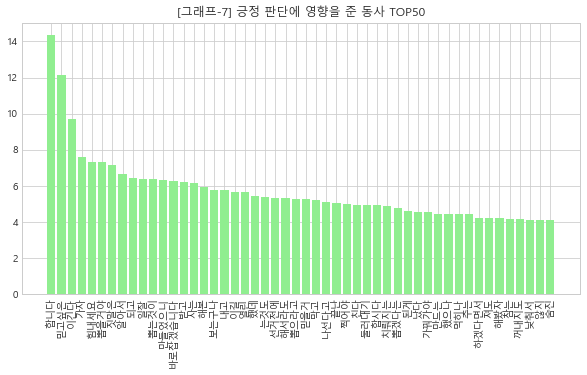

In [56]:
# 긍정 판단에 영향을 주는 동사 top 50
np.array(verb_list[:50])[:,1]

plt.bar( np.array(verb_list[:50])[:,1],
         np.array(verb_list[:50])[:,0].astype(float), color='lightgreen')
plt.title('[그래프-7] 긍정 판단에 영향을 준 동사 TOP50')
plt.xticks(rotation=90)
plt.show()

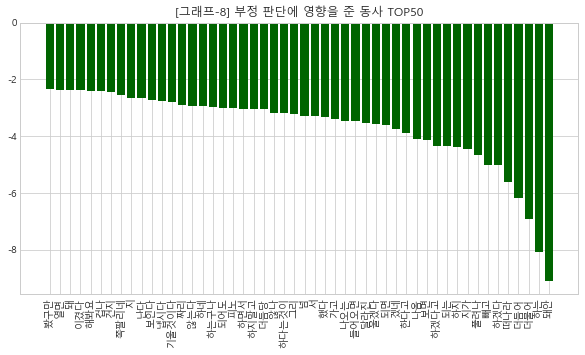

In [57]:
# 부정 판단에 영향을 주는 동사사 top 50
np.array(verb_list[-50:])[:,1]

plt.bar( np.array(verb_list[-50:])[:,1],
         np.array(verb_list[-50:])[:,0].astype(float), color='darkgreen')
plt.title('[그래프-8] 부정 판단에 영향을 준 동사 TOP50')
plt.xticks(rotation=90)
plt.show()

### 5.7 모든 형태소 리스트

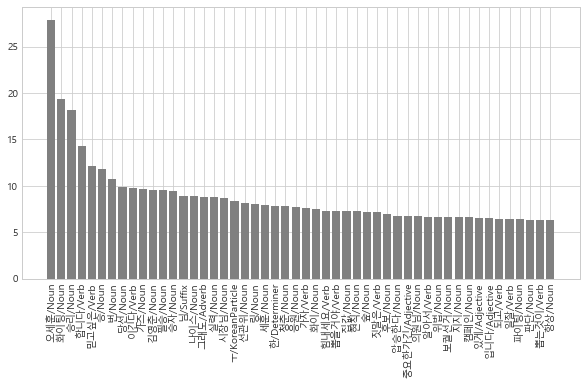

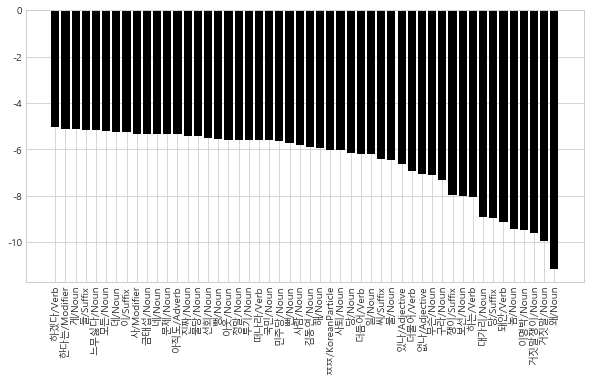

In [58]:
plt.bar( np.array(coef_pos_text[:50])[:,1],
         np.array(coef_pos_text[:50])[:,0].astype(float), color='grey')
plt.xticks( rotation=90)
plt.show()

plt.bar( np.array(coef_pos_text[-50:])[:,1],
         np.array(coef_pos_text[-50:])[:,0].astype(float), color='black')
plt.xticks( rotation=90)
plt.show()

### 5.8 리스트 저장

In [59]:
import pickle

# 명사 리스트 저장
with open('data/05.단어사전 만들기/noun_list.pickle', 'wb') as f:
    pickle.dump(noun_list, f, pickle.HIGHEST_PROTOCOL)
    
# 형용사 리스트 저장
with open('data/05.단어사전 만들기/adjective_list.pickle', 'wb') as f:
    pickle.dump(adjective_list, f, pickle.HIGHEST_PROTOCOL)

# 동사 리스트 저장
with open('data/05.단어사전 만들기/verb_list.pickle', 'wb') as f:
    pickle.dump(verb_list, f, pickle.HIGHEST_PROTOCOL)
    
# 모든 단어 리스트 저장
with open('data/05.단어사전 만들기/coef_pos_text.pickle', 'wb') as f:
    pickle.dump(coef_pos_text, f, pickle.HIGHEST_PROTOCOL)

In [60]:
len(coef_pos_text)

20238